In [18]:
import sys 
sys.path.append('../../')

import numpy as np
from functions.utils import * 
from collections import defaultdict
import os
# os.environ["CUDA_DEVICE_ORDER"]=""   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

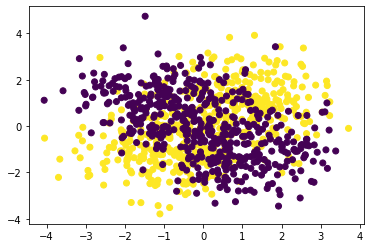

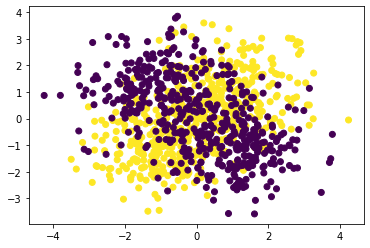

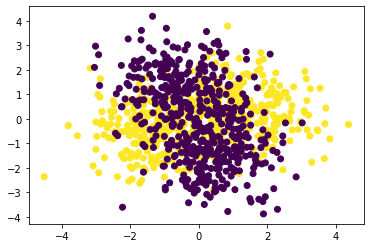

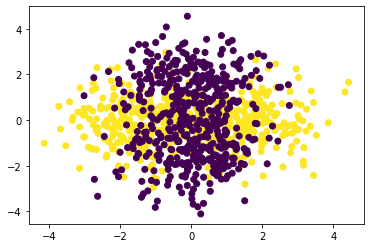

In [19]:
train_x, train_y = generate_gaussian_parity(n=1000, cov_scale=1, angle_params=0, acorn=0)
plt.scatter(train_x[:,0], train_x[:,1], c=train_y)
plt.show()

test_x, test_y = generate_gaussian_parity(n=1000, cov_scale=1, angle_params=0, acorn=1)
plt.scatter(test_x[:,0], test_x[:,1], c=test_y)
plt.show()

test_x, test_y = generate_gaussian_parity(n=1000, cov_scale=1, angle_params=45/2, acorn=1)
plt.scatter(test_x[:,0], test_x[:,1], c=test_y)
plt.show()

test_x, test_y = generate_gaussian_parity(n=1000, cov_scale=1, angle_params=45, acorn=1)
plt.scatter(test_x[:,0], test_x[:,1], c=test_y)
plt.show()

In [55]:
def _prep_dataset(X, y, seed=None):
    np.random.seed(seed)
    perm = np.random.permutation(X.shape[0])
    X, y  = X[perm,:], y[perm]

    X = torch.FloatTensor(X)
    y = (torch.FloatTensor(y).unsqueeze(-1))#[:,0]
    return {'X': X, 'y': y}
    

def run_experiment(depth, iterations, reps=100, width=3, cov_scale=1):
    result = lambda: None
    
    xx, yy = np.meshgrid(np.arange(-2, 2, 4 / 100), np.arange(-2, 2, 4 / 100))
    true_posterior = np.array([pdf(x) for x in (np.c_[xx.ravel(), yy.ravel()])])
    
    rep_full_list = []
    imgs = []
    datasets = {
        'train': _prep_dataset(*generate_gaussian_parity(n=1000, cov_scale=cov_scale, angle_params=0, acorn=0), seed=0),
        'test': _prep_dataset(*generate_gaussian_parity(n=1000, cov_scale=cov_scale, angle_params=0, acorn=1), seed=1),
        'ood_22': _prep_dataset(*generate_gaussian_parity(n=1000, cov_scale=cov_scale, angle_params=45/2, acorn=1), seed=1),
        'ood_45': _prep_dataset(*generate_gaussian_parity(n=1000, cov_scale=cov_scale, angle_params=45, acorn=1), seed=1),
    }
    
    # dataset -> metric -> [list over reps]
    results_dict = {key: defaultdict(list) for key in datasets.keys()}
    results_dict['n_parameters'] = []

    depth = depth
    penultimate_vars_reps = []
    for rep in range(reps):#25
        print('rep: ' + str(rep))
        
        for i in range(1, iterations):#20
            print('now running', i)

            ## Increasing Depth
            if depth:
                if i < 5:
                    model = get_model(n_hidden = i, hidden_size=i, penultimate=False, bn=False, use_cuda=False)
                else:
                    model = get_model(n_hidden = i, penultimate=False, bn=False, use_cuda=False)
            else:
            ## Increasing Width
                model = get_model(hidden_size = i, n_hidden=width, penultimate=False, bn=False, use_cuda=False)

            # Train model
            n_par = sum(p.numel() for p in model.parameters())
            losses = train_model(model, datasets['train']['X'], datasets['train']['y'])

            # Extract dataset metrics
            with torch.no_grad():
                for key, ds in datasets.items():
                    logits = model(ds['X'])
                    y_true = ds['y'].type_as(logits)
                    
                    loss = torch.nn.BCEWithLogitsLoss()(logits, y_true)
                    results_dict[key]['loss'].append(loss)

                    pred_poster = torch.sigmoid(logits)
                    pred_label = pred_poster.round()
                    
                    acc = (pred_label == y_true).sum().cpu().data.numpy().item() / y_true.size(0)
                    results_dict[key]['01_error'].append(1 - acc)
                    
                    pred_poster = pred_poster.cpu().numpy()
                    pred_label = pred_label.cpu().numpy()
                    y_true = y_true.cpu().numpy()
                    
                    full_act, pen_act = get_activation_mat(model, ds['X'], return_penult=True)
                    for mat_key, mat in zip(['full', 'pen'], [full_act, pen_act]):
                        unique_poly, unique_inv = np.unique(mat, axis=0, return_inverse=True)
                        n = len(y_true)
                        assert mat.shape[0] == n
                        n_poly = len(unique_poly)
                        L_01 = np.zeros((n, n_poly))
                        L_true = np.zeros((n, n_poly))
                        L_est = np.zeros((n, n_poly))
                        L_proba = np.zeros((n, n_poly))
                        for idx, poly_idx in enumerate(unique_inv):
                            L_01[idx, poly_idx] = 1#pred_label[idx]
                            L_true[idx, poly_idx] = 2*y_true[idx]-1
                            L_est[idx, poly_idx] = 2*pred_label[idx]-1
                            L_proba[idx, poly_idx] = 2*pred_poster[idx]-1
                        results_dict[key][mat_key + '-0/1'].append(np.linalg.svd(L_01, compute_uv=False))
                        results_dict[key][mat_key + '-true_label'].append(np.linalg.svd(L_true, compute_uv=False))
                        results_dict[key][mat_key + '-est_label'].append(np.linalg.svd(L_est, compute_uv=False))
                        results_dict[key][mat_key + '-est_proba'].append(np.linalg.svd(L_proba, compute_uv=False))
            results_dict['n_parameters'].append(n_par)

    return results_dict

In [56]:
for i in range(0, 10):
    result_d_dict = run_experiment(depth=True, iterations=19, reps=1)
    result_w_dict = run_experiment(depth=False, iterations=70, reps=1)
    np.savez_compressed('./rotation_results/results_%s.npz'%str(i), result_w=result_w_dict, result_d=result_d_dict)

rep: 0
now running 1
now running 2
now running 3
now running 4
now running 5
now running 6
now running 7
now running 8
now running 9
now running 10
now running 11
now running 12
now running 13
now running 14
now running 15
now running 16
now running 17
now running 18
rep: 0
now running 1
now running 2
now running 3
now running 4
now running 5
now running 6
now running 7
now running 8
now running 9
now running 10
now running 11
now running 12
now running 13
now running 14
now running 15
now running 16
now running 17
now running 18
now running 19
now running 20
now running 21
now running 22
now running 23
now running 24
now running 25
now running 26
now running 27
now running 28
now running 29
now running 30
now running 31
now running 32
now running 33
now running 34
now running 35
now running 36
now running 37
now running 38
now running 39
now running 40
now running 41
now running 42
now running 43
now running 44
now running 45
now running 46
now running 47
now running 48
now running 49

now running 9
now running 10
now running 11
now running 12
now running 13
now running 14
now running 15
now running 16
now running 17
now running 18
now running 19
now running 20
now running 21
now running 22
now running 23
now running 24
now running 25
now running 26
now running 27
now running 28
now running 29
now running 30
now running 31
now running 32
now running 33
now running 34
now running 35
now running 36
now running 37
now running 38
now running 39
now running 40
now running 41
now running 42
now running 43
now running 44
now running 45
now running 46
now running 47
now running 48
now running 49
now running 50
now running 51
now running 52
now running 53
now running 54
now running 55
now running 56
now running 57
now running 58
now running 59
now running 60
now running 61
now running 62
now running 63
now running 64
now running 65
now running 66
now running 67
now running 68
now running 69
rep: 0
now running 1
now running 2
now running 3
now running 4
now running 5
now runni